# Latent factor based collaborative filtering을 이용한 영화추천

### 추천시스템 종류

1. 콘텐츠 기반 필터링 : 순수하게 콘텐츠의 내용만을 비교해서 추천하는 방식 ex) 아이언맨1을 봤으면 아이언맨 2, 아이언맨3을 추천해주고 마블 영화를 추천해 주는 것 (아이템의 고유의 정보를 바탕으로 아이템 간 유사성을 파악)


2. 협업 필터링 : 과거의 사용자 행동 양식(User Behavior) 데이터를 기반으로 추천하는 방식 (다수의 사용자의 아이템 구매 이력 정보만으로 사용자간 유사성 및 아이템 간 유사성을 파악 즉, 아이템 자체의 속성에 주목하지 않음)

    (1) 사용자기반 & 아이템 기반 : "평점"행렬을 이용하여 유사도를 계산하는 방식

    (2) 잠재요인 : 클릭수, 시청횟수 등 잠재적(암묵적) 요인을 이용하여 행렬 인수분해(matrix factorization)하여 각 벡터와의 연관성을 분석. 

* 암묵적 데이터 :  플레이 횟수, 플레이 시간 이외에도 클릭 수, 구매 여부, 플레이 스킵 여부, 검색 기록, 방문 페이지 이력, 구매 내역, 심지어 마우스 움직임 기록

* 명시적 데이터 : 좋아요, 별점 등

## 루브릭

| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. CSR matrix가 정상적으로 만들어졌다. | 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다. |
| 2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다. | 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다. |
| 3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다. | MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다. |

### 데이터 설명

- user_id는 사람을 의미하며 각 사람이 movie_id라는 특정 영화를 보고 ratings로 별점을 준 명시적(explicit) 평가임을 알수 있음. 

- 본 프로젝트는 암묵적(implicit) 데이터로 간주하고 테스트를 할려고 하며 별점을 시청 횟수로 간주 할려고함.

- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외함.

## 데이터 준비

In [1]:
import os
import pandas as pd

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
# ratings 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'ratings':'count'}, inplace=True)

In [4]:
ratings = ratings[['user_id', 'movie_id', 'count']]

In [5]:
ratings

,user_id,movie_id,count
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [6]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## 데이터 분석

In [7]:
# ratings에 있는 유니크한 영화 개수
ratings['movie_id'].nunique()

3628

In [8]:
# rating에 있는 유니크한 사용자 수
ratings['user_id'].nunique()

6039

In [9]:
# 가장 인기있는 영화 30개(인기순)
movie_data = pd.merge(ratings, movies)
movie_count = movie_data.groupby('title')['count'].count()
movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

## 내가 선호하는 영화를 5가지 골라서 목록에 추가

In [10]:
my_favorite = ['Godfather, The (1972)' , 'Back to the Future (1985)' ,'Matrix, The (1999)' ,'Men in Black (1997)' ,'Jurassic Park (1993)']

favorite_movie_id = movies[movies['title'].isin(my_favorite)]

# user_id 가 6041인 사람이 위 좋아하는 영화를 5번씩 봣다고 가정함.
my_movie = pd.DataFrame({'user_id': [6041]*5, 'movie_id': favorite_movie_id['movie_id'], 'count':[5]*5})

if not ratings.isin({'user_id':[6041]})['user_id'].any():
    ratings = ratings.append(my_movie)

# user_id에 6041이라는 데이터가 없다면 위에 임으로 만든 my_favorite데이터를 추가함. 
    
ratings.tail(10)

,user_id,movie_id,count
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
476,6041,480,5
847,6041,858,5
1250,6041,1270,5
1539,6041,1580,5
2502,6041,2571,5


In [13]:
favorite_movie_id

,movie_id,title,genre
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi
847,858,"Godfather, The (1972)",Action|Crime|Drama
1250,1270,Back to the Future (1985),Comedy|Sci-Fi
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


In [14]:
movie_data = pd.merge(ratings, movies, on='movie_id')
movie_data

,user_id,movie_id,count,title,genre
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...
836478,5851,3607,5,One Little Indian (1973),Comedy|Drama|Western
836479,5854,3026,4,Slaughterhouse (1987),Horror
836480,5854,690,3,"Promise, The (Versprechen, Das) (1994)",Romance
836481,5938,2909,4,"Five Wives, Three Secretaries and Me (1998)",Documentary


## 데이터 전처리 (Indexing)

- Movielens 데이터는 rating.dat 안에 이미 데이터를 인덱싱처리하였기 때문에 본 프로젝트에서는 생략함

In [44]:
# 고유한 유저를 찾아내는 코드
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

- uinque() : 데이터에 교유값들이 어떠한 종류들이 있는지 알고 싶을 때 사용하는 함수

- nunique() : 데이터에 고유값들의 수를 출력해주는 함수

In [52]:
# # 유저를 indexing 하는 코드 idx는 index의 약자임
# num_user_idx = {v:k for k,v in enumerate(num_user)}
# num_movie_idx = {v:k for k,v in enumerate(num_movie)}

In [50]:
# # 인덱싱이 잘 되었는지 확인
# print(num_user_idx['6041'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
# print(num_movie_idx['Godfather, The (1972)'])

In [51]:
# # indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# # dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고.

# # user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# # 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 

# temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
# if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
#     print('user_id column indexing OK!!')
#     data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
# else:
#     print('user_id column indexing Fail!!')

# # artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
# temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
# if len(temp_artist_data) == len(data):
#     print('artist column indexing OK!!')
#     data['artist'] = temp_artist_data
# else:
#     print('artist column indexing Fail!!')

# data

## Matrix Factorization(MF) 의 개념

행렬 인수분해(matrix factorization) 
:인수분해와 비슷하다고 볼 수 있음. 30을 인수분해하면 30 = 6X5 = 3X10 = 1X30 이런 식으로 곱하기로 나타낼 수 있음. 행렬도 이렇게 곱으로 분해 할 수 있으며, 분해 행렬을 사용하면 원하는 답을 더 쉽게 찾을 수 있음

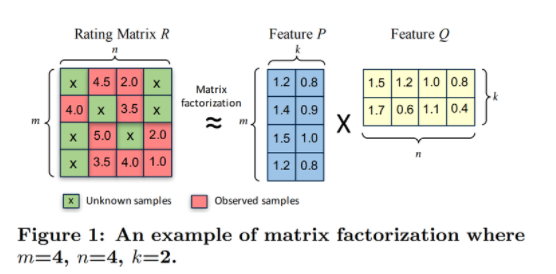

(m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현 가능할 수 있다는 간단한 예시임.

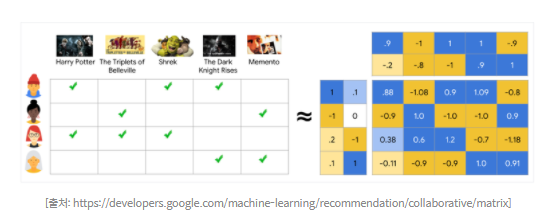

위 그림은 m=4, n=5, k=2인 MF 모델 예시임.

- (m, k) 사이즈의 Feature Matrix P는 k 차원의 벡터를 사용자 수만큼 모아놓은 행렬이며. 그렇다면 아래 그림에서 첫 번째 벡터 Po =(1, 0.1)은 바로 빨간 모자를 쓴 첫 번째 사용자의 특성(Feature) 벡터가 됨


- 같은 방식으로 Q해열의 첫 번째 벡터 Qo=(0.9,-0.2)는 해리포터의 영화의 특성 벡터가 됨. 


-  MF 모델은 이 두 벡터를 내적해서 얻어지는 0.88이 바로 Ro,o  으로 정의되는 사용자의 영화 선호도로 보는 모델이 됨.

###### 따라서, 모델의 목표는 모든 유저와 아이템에 대해 k-dimension의 벡터를 잘 만드는 것임.

- 벡터를 잘 만드는 기준은 유저 i의 벡터(Ui) 와 아이템 j의 벡터(Ij)를 내적했을 때 유저 i가 아이템 j에 대해 평가한 수치(M_ij)와 비슷한지가 됨.

## Compressed Sparse Row Matrix

CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조임

CSR Matrix는 data, indices, indptr 로 행렬을 압축하여 표현함.


In [26]:
csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.movie_id)))
csr_data

<6042x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [43]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관함..
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

- implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지임.


- 이 패키지에 구현된 ALS(AlternatingLeastSquares) 모델을 사용


- Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적임

AlternatingLeastSquares 클래스의 __init__ 파라미터

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미. 데이터를 몇 번 반복해서 학습할 것인지
- 1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 함.

In [28]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [30]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줌.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3953x6042 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

# 모델 학습

In [31]:
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 모델 평가

학습 종료 후 밑에 두가지 사항을 살펴봐야됨.

- 벡터와 벡터를 어떻게 연결하고 만들고 있는지
- 두 벡터를 곱하면 어떤 값이 나오는지

In [34]:
my_vector, godfather_vector = als_model.user_factors[6041], als_model.item_factors[858]

In [35]:
my_vector

array([-1.1380961 , -0.08401596, -0.2526253 ,  0.03344624, -0.17521828,
        0.24294089, -0.13257936, -1.2515655 , -0.12405051,  1.8799237 ,
       -0.21173294, -0.24080366,  0.26335016,  0.56029713, -0.08341967,
        0.91661316,  0.10182402,  0.07228909,  0.7348142 , -1.1583918 ,
       -0.54976034, -0.5966688 , -0.01989051,  0.4566426 , -0.7789717 ,
       -0.28969643,  0.27198654,  0.19102247,  0.5501631 , -0.06320523,
        0.0414704 ,  0.22727233,  0.232746  ,  0.6060491 , -0.6120209 ,
       -0.58360595,  0.15840836, -1.2784988 ,  0.46778116, -0.01094715,
       -0.75131965, -0.0627657 , -0.5806418 , -0.28428364,  0.17710759,
        0.47907555, -0.95878196,  0.5704409 ,  0.4026434 ,  0.41040102,
       -0.84226114, -0.4376042 ,  0.14359148,  0.44332826,  0.25383148,
       -0.08421011,  0.4321031 ,  0.36277336,  0.39159447,  0.37424672,
        0.6690559 ,  0.62735665,  0.28489274,  0.297499  ,  0.41841853,
       -0.17258415,  0.23965417, -0.29527077,  0.27387863,  0.57

In [36]:
godfather_vector

array([ 0.0064025 , -0.01427185, -0.01260002,  0.04808629, -0.01962117,
        0.01332023, -0.01221004, -0.01721214,  0.00685121,  0.03996641,
        0.02863934,  0.00507676,  0.02342962,  0.01855711, -0.01115042,
        0.02574529, -0.01390998,  0.06551163, -0.00636542, -0.01452477,
       -0.04207899,  0.01849   ,  0.03001753,  0.04097673, -0.03574093,
       -0.00123086,  0.02377551, -0.03306563,  0.04013443, -0.00655483,
        0.00265506,  0.00318816,  0.01661018,  0.02851485, -0.03063551,
       -0.01174517,  0.00736051, -0.04148335, -0.01121381, -0.01421042,
       -0.0117127 ,  0.0270109 ,  0.01653394,  0.00715434,  0.00984336,
        0.03131477, -0.01240849,  0.0268324 ,  0.02177345,  0.00412722,
       -0.0137929 , -0.00455817, -0.05591973,  0.01659842, -0.00133362,
       -0.01223587,  0.00855583,  0.03641456, -0.02785697,  0.03024542,
       -0.00178703,  0.0323625 , -0.04067596,  0.02212025,  0.02458659,
        0.00250596,  0.04277348,  0.0267633 ,  0.02516322,  0.04

In [37]:
np.dot(my_vector, godfather_vector)

0.60437554

In [38]:
toystory_vector = als_model.item_factors[1]
np.dot(my_vector, toystory_vector)

0.106151104

## 내가 좋아하는 영화와 비슷한 영화 추천 받기

In [39]:
favorite_movie = 'Godfather, The (1972)'
movie_id = movies[movies['title']=='Godfather, The (1972)']['movie_id']
similar_movie = als_model.similar_items(movie_id.values[0], N=15)
similar_movie

[(858, 1.0),
 (1221, 0.9659428),
 (2023, 0.5382678),
 (1953, 0.47077432),
 (624, 0.36178377),
 (2695, 0.3592963),
 (923, 0.35537115),
 (1787, 0.342897),
 (3595, 0.32988063),
 (2887, 0.32511464),
 (1213, 0.31958544),
 (872, 0.3163107),
 (2194, 0.29634884),
 (111, 0.29585117),
 (2101, 0.29392362)]

In [40]:
movies[movies['movie_id'].isin([s[0] for s in similar_movie])]

,movie_id,title,genre
109,111,Taxi Driver (1976),Drama|Thriller
619,624,Condition Red (1995),Action|Drama|Thriller
847,858,"Godfather, The (1972)",Action|Crime|Drama
861,872,Aiqing wansui (1994),Drama
911,923,Citizen Kane (1941),Drama
1195,1213,GoodFellas (1990),Crime|Drama
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
1728,1787,Paralyzing Fear: The Story of Polio in America...,Documentary
1884,1953,"French Connection, The (1971)",Action|Crime|Drama|Thriller
1954,2023,"Godfather: Part III, The (1990)",Action|Crime|Drama


## 내가 좋아할만한 영화 추천받기

In [41]:
user = 6041
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(589, 0.6404527),
 (1221, 0.52842623),
 (2916, 0.4389851),
 (1210, 0.3550697),
 (1196, 0.35287076),
 (260, 0.3520635),
 (1573, 0.3205241),
 (110, 0.31481212),
 (1240, 0.28999066),
 (1527, 0.26928657),
 (780, 0.25390488),
 (3793, 0.24261561),
 (1544, 0.22030604),
 (2023, 0.21708938),
 (1193, 0.21314166),
 (3175, 0.21149874),
 (1584, 0.20927137),
 (457, 0.2019396),
 (1198, 0.20074975),
 (2028, 0.20045468)]

In [42]:
movies[movies['movie_id'].isin([m[0] for m in movie_recommended])]

,movie_id,title,genre
108,110,Braveheart (1995),Action|Drama|War
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
453,457,"Fugitive, The (1993)",Action|Thriller
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
770,780,Independence Day (ID4) (1996),Action|Sci-Fi|War
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1180,1198,Raiders of the Lost Ark (1981),Action|Adventure
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama


# Report

- latent factor 중 시청 횟수를 이용한 collaborative filtering을 적용하였음.


- Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식을 적용하였음.


- 결과적으로 20개의 영화를 추천받았음.